In [1]:
import types
import matplotlib.pyplot as plt
import time

# mxnet imports
import mxnet as     mx
from   mxnet import nd
from   mxnet import autograd
from mxnet.gluon.nn.basic_layers import Activation

# standalone lrp imports
import numpy as np
na = np.newaxis
from mxmodules import Sequential, Linear, Rect, Tanh
import model_io, data_io

# LRP using GLUON Hybridblocks

### Current functionality:
- patch the hybrid_forward of dense layers with activation to enable lrp in the backward pass
- normal run and hybridized run for fully-connected networks

### Current issues:
- not working with float 64, therefore not exacltly comparable to numpy version
- extracting and running the symbolic program doesn't work - misunderstood it? 

### Other TODOS:
- find better solution than block_grad method to change activation backward pass to identity

## Load Patched Functions

In [2]:
from mxlrp import dense_hybrid_forward_lrp

def patch_lrp_gradient_dense(net):
    for layer in net._children:
        if layer.__class__.__name__ == 'Dense':
            layer.hybrid_forward = types.MethodType(dense_hybrid_forward_lrp, layer)

## Define Context

In [3]:
ctx = mx.gpu()


# TODO: float64 doesn't work in patched backward pass
# mxnet standard is float32, use float64 to compare with numpy results
dtype='float32'

## 1. Model Definition

In [4]:
## ############## ##
# STANDALONE MODEL #
## ############## ##

long_rect_sta = model_io.read('../models/MNIST/long-rect.nn') # 99.17% prediction accuracy

# remove softmax layer for simplicity
# TODO: add softmax layer treatment and remove this part
long_rect_sta.modules = long_rect_sta.modules[:-1]

loading pickled model from ../models/MNIST/long-rect.nn


In [5]:
## ######### ##
# GLUON MODEL #
## ######### ##
def translate_to_gluon(nn_sta, ctx=mx.cpu(), dtype='float32'):

    nn_gluon = mx.gluon.nn.HybridSequential()

    print('INPUT NETWORK:\n')
    
    print('-----------------')
    for m_ind, mod in enumerate(nn_sta.modules):

        if m_ind < len(nn_sta.modules) - 1:
            next_module_name = nn_sta.modules[m_ind + 1].__class__.__name__
        else:
            next_module_name = None

        
        print(mod.__class__.__name__)

        if mod.__class__.__name__ == 'Linear':

            if next_module_name == 'Rect':
                activation = 'relu'
            else:
                activation = None

            weight = mod.W
            bias   = mod.B

            print('W : {}'.format(weight.shape))
            print('B : {}'.format(bias.shape))
            print('-----------------')

            # reproduce Linear layer in gluon
            dense = mx.gluon.nn.Dense(units=weight.shape[1], in_units=weight.shape[0], use_bias=True, activation=activation)
            dense.collect_params().initialize(ctx=ctx)
            dense.weight.set_data(nd.array(weight.T, dtype=dtype))
            dense.bias.set_data(  nd.array(bias,     dtype=dtype))

            nn_gluon.add(dense)
            
        else:
            print('-----------------')
    
    print('\n\n')
    
    print('OUTPUT NETWORK:')
    print('-----------------')
    print(nn_gluon)
    
    return nn_gluon


long_rect_gluon = translate_to_gluon(long_rect_sta, ctx, dtype)

INPUT NETWORK:

-----------------
Linear
W : (784, 1296)
B : (1296,)
-----------------
Rect
-----------------
Linear
W : (1296, 1296)
B : (1296,)
-----------------
Rect
-----------------
Linear
W : (1296, 1296)
B : (1296,)
-----------------
Rect
-----------------
Linear
W : (1296, 10)
B : (10,)
-----------------



OUTPUT NETWORK:
-----------------
HybridSequential(
  (0): Dense(784 -> 1296, Activation(relu))
  (1): Dense(1296 -> 1296, Activation(relu))
  (2): Dense(1296 -> 1296, Activation(relu))
  (3): Dense(1296 -> 10, linear)
)


## 2. Patch Gluon Gradient to LRP

In [6]:
patch_lrp_gradient_dense(long_rect_gluon)

## 3. Compare To Standalone Implementation 

In [7]:
## ######## ##
# LOAD MNIST #
## ######## ##
X = data_io.read('../data/MNIST/test_images.npy')
Y = data_io.read('../data/MNIST/test_labels.npy')

X = X.astype(np.float32)
Y = Y.astype(np.float32)

# transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
X =  X / 127.5 - 1

# transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
I = Y[:,0].astype(int)
Y = np.zeros([X.shape[0],np.unique(Y).size])
Y[np.arange(Y.shape[0]),I] = 1

loading np-formatted data from ../data/MNIST/test_images.npy
loading np-formatted data from ../data/MNIST/test_labels.npy


In [8]:
batch_size = 256
yselect    = 3
num_runs   = 10

yselect = (np.arange(Y.shape[1])[na,:] == yselect) * np.ones((batch_size, Y.shape[1]))
im = X[:batch_size]

im_mx      = nd.array(im,      ctx=ctx, dtype=dtype)
yselect_mx = nd.array(yselect, ctx=ctx, dtype=dtype) 

In [9]:
## ######## ##
# STANDALONE #
## ######## ##
sta_times = []
for i in range(num_runs):
    strt = time.time()
    
    pred_sta   = long_rect_sta.forward(im)
    hm_sta     = long_rect_sta.lrp(yselect)
    
    stp = time.time()
    sta_times.append(stp-strt)
sta_times = np.array(sta_times)
time_sta = np.mean(sta_times)

## ###### ##
# GLUON ND #
## ###### ##
im_mx.attach_grad()

gluon_times = []
for i in range(num_runs):
    strt = time.time()
    with autograd.record():
        pred_gluon = long_rect_gluon(im_mx)
    pred_gluon.backward(yselect_mx)

    hm_gluon = im_mx.grad

    hm_gluon   = hm_gluon.asnumpy()
    pred_gluon = pred_gluon.asnumpy()

    stp = time.time()
    gluon_times.append(stp-strt)
gluon_times = np.array(gluon_times)
time_gluon = np.mean(gluon_times)

## ############## ##
# GLUON HYBRIDIZED #
## ############## ##
long_rect_gluon.hybridize()

hg_times = []
for i in range(num_runs):
    strt = time.time()
    with autograd.record():
        pred_hg = long_rect_gluon(im_mx)
    pred_hg.backward(yselect_mx)

    hm_hg = im_mx.grad

    hm_hg   = hm_hg.asnumpy()
    pred_hg = pred_hg.asnumpy()

    stp = time.time()
    hg_times.append(stp-strt)
hg_times = np.array(hg_times)
time_hg = np.mean(hg_times)

### BENCHMARKS:

In [10]:
# numerically compare heatmaps, check how much difference float32 (np) / float 64 (mx) makes
prec_pred = -1
while np.allclose(pred_sta, pred_hg, atol=10**(-prec_pred)):
        prec_pred+=1
prec_lrp  = -1
while np.allclose(hm_sta, hm_hg, atol=10**(-prec_lrp)):
        prec_lrp+=1

In [11]:
print('## ######## ##')
print('# EVALUATION #')
print('## ######## ##')

print('Comparison on Long-Rect network (4 fully-connected layers)\n')

print('1. TIME')

print('gluon running on {} averaged over {} runs'.format(ctx, num_runs))
print('')
print('Standalone: calculated predictions and heatmaps for {} images in {:4f} s'.format(batch_size, time_sta))
print('Gluon ND  : calculated predictions and heatmaps for {} images in {:4f} s'.format(batch_size, time_gluon))
print('Gluon HYB : calculated predictions and heatmaps for {} images in {:4f} s'.format(batch_size, time_hg))
print('')
print('Speedup Gluon (non-hybridized): {:2f} faster than standalone'.format(time_sta / time_gluon))
print('Speedup Gluon (    hybridized): {:2f} faster than standalone'.format(time_sta / time_hg))
print('')

print('2. RESULT')
if prec_pred >= 0:
    print('Predictions are the same up to absolute tolerance 10e-{}'.format(prec_pred))
else:
    print('ERROR: Standalone / Gluon predictions differ')
if prec_lrp >= 0:
    print('Relevances  are the same up to absolute tolerance 10e-{}'.format(prec_lrp))
else:
    print('ERROR: Standalone / Gluon lrp relevances differ')

## ######## ##
# EVALUATION #
## ######## ##
Comparison on Long-Rect network (4 fully-connected layers)

1. TIME
gluon running on gpu(0) averaged over 10 runs

Standalone: calculated predictions and heatmaps for 256 images in 8.294691 s
Gluon ND  : calculated predictions and heatmaps for 256 images in 0.210242 s
Gluon HYB : calculated predictions and heatmaps for 256 images in 0.202478 s

Speedup Gluon (non-hybridized): 39.453084 faster than standalone
Speedup Gluon (    hybridized): 40.965838 faster than standalone

2. RESULT
Predictions are the same up to absolute tolerance 10e-6
Relevances  are the same up to absolute tolerance 10e-2


Standalone pred:
[ -9.48233086   1.71360086   4.67001054   6.85639312   1.97421741
  -7.9058102  -18.26386265  22.67048783  -1.95408201   2.51839859]
Gluon      pred:
[ -9.48233128   1.71359873   4.67001104   6.85639477   1.9742204
  -7.90581131 -18.26386833  22.67049408  -1.95408142   2.51839566]


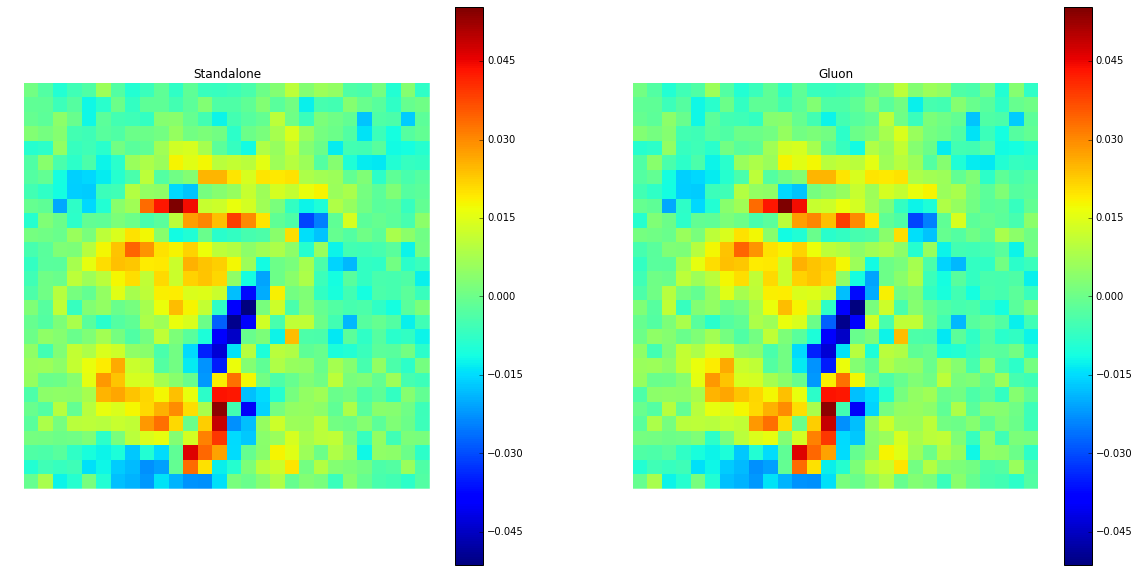

Standalone pred:
[  5.83397211e+00   3.85374902e+00   3.40239709e+01  -7.57432902e+00
  -8.98199212e+00  -1.98392463e+01   8.54631480e-01   1.79442799e-02
  -5.11117585e+00  -2.11245377e+00]
Gluon      pred:
[  5.83396816e+00   3.85375476e+00   3.40239830e+01  -7.57433224e+00
  -8.98199463e+00  -1.98392429e+01   8.54632258e-01   1.79470778e-02
  -5.11118126e+00  -2.11245155e+00]


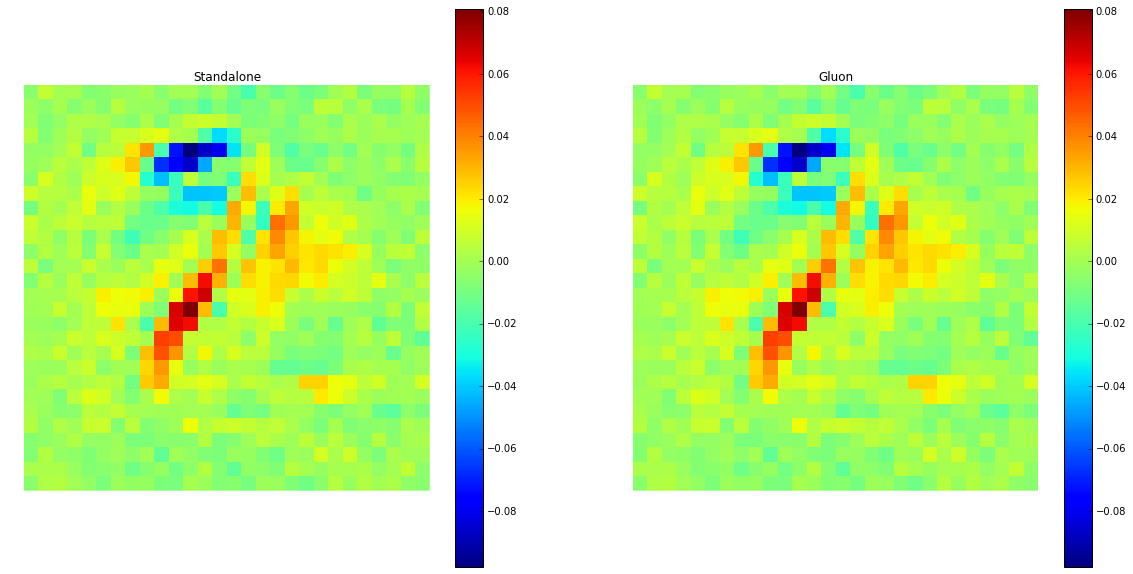

Standalone pred:
[ -6.40243205  24.28400647  -3.92706751  -5.12073435   2.33981446
  -8.09535567   2.72465504   5.80491028  -0.54311993  -9.12971107]
Gluon      pred:
[ -6.40243244  24.28398705  -3.92706871  -5.12072992   2.33981156
  -8.09535313   2.72465372   5.80491161  -0.543118    -9.12971783]


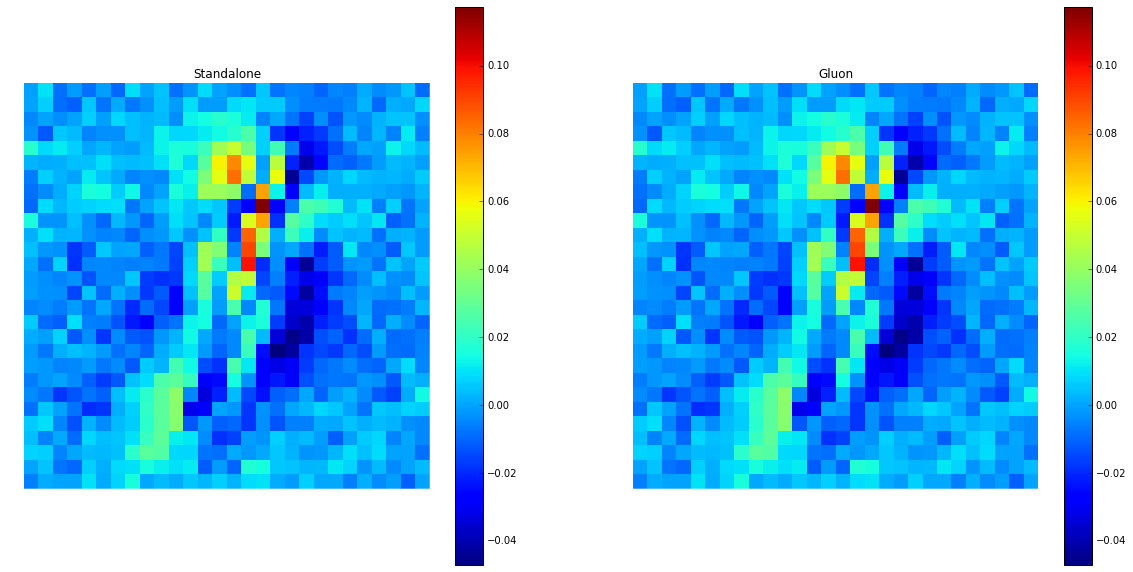

In [12]:
num_images = 3

for i in range(num_images):

    print('Standalone pred:\n{}'.format(pred_sta[i]))
    print('Gluon      pred:\n{}'.format(pred_gluon[i]))
    
    fig = plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.title('Standalone')
    plt.imshow(hm_sta[i].reshape(28, 28), interpolation='none')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Gluon')
    plt.imshow(hm_hg[i].reshape(28, 28), interpolation='none')
    plt.colorbar()
    plt.axis('off')

    plt.show()